In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
#import datapane as dp
#import altair as alt
from datetime import datetime
from statsmodels.tsa.filters.hp_filter import hpfilter
import openpyxl
from sklearn.preprocessing import Binarizer,OneHotEncoder,OrdinalEncoder,LabelEncoder
from plotly import __version__
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
#from bq_helper import BigQueryHelper
from google.cloud import bigquery

In [ ]:
%load_ext google.colab.data_table

Big Query Inline

In [ ]:
%%bigquery --project 623862343257 df
#symmetric-fold-324307
select * from bigquery-public-data.openaq.global_air_quality

In [ ]:
df = pd.DataFrame(df)

Big Query Pandas


In [ ]:
project_id = '623862343257'

In [ ]:
client = bigquery.Client(project=project_id)

sample_count = 2000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.chicago_crime.crime`
  ''').to_dataframe().total[0]

df = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.chicago_crime.crime`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

print('Full dataset has %d rows' % row_count)

Full dataset has 7396346 rows


In [ ]:
from vega_datasets import data

In [ ]:
df.head()

unique_key case_number  ...  longitude                       location
0     5610916    HN418184  ... -87.602281  (41.731869823, -87.602280887)
1     6390026    HP475309  ... -87.673501   (41.71830485, -87.673501486)
2     4050557    HL401414  ... -87.604319   (41.692833841, -87.60431945)
3        4031    HN273962  ... -87.739671  (41.772446057, -87.739670791)
4     6776324    HR190715  ... -87.789157  (41.993197149, -87.789157198)

[5 rows x 22 columns]

In [ ]:
df['date'] = pd.to_datetime(df['date'],utc=True)

In [ ]:
df['arrest'] = (df['arrest']==True)*1

In [ ]:
df['domestic'] = (df['domestic']==True)*1

In [ ]:
df.loc[:,'Month'] = df['date'].apply(lambda x:x.month)

In [ ]:
df.loc[:,'Day'] = df['date'].apply(lambda x:x.day)

In [ ]:
df.loc[:,'Hour'] = df.loc[:,'date'].apply(lambda x:x.hour)

In [ ]:
df.loc[df['description'].isnull()==True,'description'] = 'Undefined'
df.loc[df['location_description'].isnull()==True,'location_description'] = 'Undefined'


In [ ]:
df.loc[df['primary_type'].isnull()==True,'primary_type'] = 'Undefined'

In [ ]:
df.groupby('primary_type',as_index=False).agg({'year':max,'Month':max})#.sort_values('date',ascending=False)

primary_type  year  Month
0                               ARSON  2020     11
1                             ASSAULT  2021     12
2                             BATTERY  2021     12
3                            BURGLARY  2021     12
4   CONCEALED CARRY LICENSE VIOLATION  2019      6
5                 CRIM SEXUAL ASSAULT  2019     11
6                     CRIMINAL DAMAGE  2021     12
7             CRIMINAL SEXUAL ASSAULT  2019      8
8                   CRIMINAL TRESPASS  2021     12
9                  DECEPTIVE PRACTICE  2021     12
10                           GAMBLING  2012     10
11                           HOMICIDE  2021      8
12   INTERFERENCE WITH PUBLIC OFFICER  2021      5
13                       INTIMIDATION  2010     12
14                         KIDNAPPING  2004      6
15               LIQUOR LAW VIOLATION  2004     10
16                MOTOR VEHICLE THEFT  2021     12
17                          NARCOTICS  2021     12
18         OFFENSE INVOLVING CHILDREN  2020     12
19                      OTHER OFFENSE  2021     12
20                       PROSTITUTION  2019     12
21             PUBLIC PEACE VIOLATION  2015     11
22                            ROBBERY  2021     12
23                        SEX OFFENSE  2019     12
24                           STALKING  2012      5
25                              THEFT  2021     12
26                  WEAPONS VIOLATION  2021     12

In [ ]:
!pip install haversine

In [ ]:
lat_mean=df[df.ward==28].latitude.mean()
long_mean=df[df.ward==28].longitude.mean()
location_mean=[lat_mean,long_mean]

from haversine import *
def haversine_np(lon1, lat1):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, long_mean, lat_mean])

    distance_lon = lon2 - lon1
    distance_lat = lat2 - lat1

    a = np.sin(distance_lat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(distance_lon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df['distance']=df.apply(lambda x: haversine_np(x.longitude,x.latitude),axis=1)

In [ ]:
df = df.drop(['updated_on','location','case_number','iucr','x_coordinate','y_coordinate'],axis=1) #,'unique_key'

In [ ]:
df.groupby(['primary_type'])['arrest'].sum().sort_values(ascending=False)

primary_type
NARCOTICS                           225
BATTERY                              96
THEFT                                63
CRIMINAL TRESPASS                    37
ASSAULT                              31
WEAPONS VIOLATION                    17
OTHER OFFENSE                        14
DECEPTIVE PRACTICE                   14
PROSTITUTION                         13
CRIMINAL DAMAGE                      13
OFFENSE INVOLVING CHILDREN            9
MOTOR VEHICLE THEFT                   8
ROBBERY                               8
PUBLIC PEACE VIOLATION                7
LIQUOR LAW VIOLATION                  5
BURGLARY                              4
INTERFERENCE WITH PUBLIC OFFICER      3
HOMICIDE                              3
SEX OFFENSE                           3
GAMBLING                              1
CRIM SEXUAL ASSAULT                   1
KIDNAPPING                            0
ARSON                                 0
Name: arrest, dtype: int64

In [ ]:
df.groupby(['ward'])['arrest'].sum().sort_values(ascending=False)

ward
28.0    38
27.0    31
17.0    27
29.0    27
3.0     25
24.0    25
6.0     24
37.0    23
42.0    20
20.0    18
15.0    17
16.0    15
21.0    13
1.0     13
8.0     13
9.0     12
4.0     12
2.0     12
10.0    11
49.0    11
34.0    10
11.0    10
26.0     9
7.0      9
23.0     8
46.0     8
5.0      6
35.0     6
44.0     6
18.0     6
33.0     6
14.0     5
19.0     5
48.0     5
12.0     4
25.0     4
22.0     4
36.0     4
39.0     4
13.0     3
30.0     3
31.0     3
32.0     3
40.0     3
45.0     3
47.0     3
38.0     2
43.0     2
41.0     1
50.0     0
Name: arrest, dtype: int64

In [ ]:
df2=df.groupby('year')['arrest'].transform('size')

In [ ]:
df[df['ward']==28].groupby('primary_type').count()['arrest'].sort_values(ascending=False)

primary_type
NARCOTICS              24
BATTERY                18
CRIMINAL DAMAGE        11
THEFT                   8
ROBBERY                 7
ASSAULT                 6
OTHER OFFENSE           4
WEAPONS VIOLATION       2
MOTOR VEHICLE THEFT     2
DECEPTIVE PRACTICE      2
CRIMINAL TRESPASS       2
BURGLARY                2
PROSTITUTION            1
Name: arrest, dtype: int64

In [ ]:
#Define Safe|Unsafe for reigions which are close to ward=28(most dangrous location)

In [ ]:
df['block'] = pd.factorize(df["block"])[0]
#df['iucr'] = pd.factorize(df["iucr"])[0]

In [ ]:
%unload_ext google.colab.data_table

In [ ]:
df.head()

date  block  ... Hour   distance
0 2017-05-13 14:30:00+00:00      0  ...   14  10.838640
1 2009-11-05 14:45:00+00:00      1  ...   14   8.865882
2 2012-08-19 21:31:00+00:00      2  ...   21  23.193716
3 2010-10-22 00:00:00+00:00      3  ...    0  10.321855
4 2003-08-03 21:00:00+00:00      4  ...   21  23.729117

[5 rows x 19 columns]

In [ ]:
df['fbi_code'].value_counts()

06     427
08B    322
14     223
18     196
26     188
05     117
08A    105
07      98
03      67
11      60
04B     52
15      27
04A     23
24      22
16      17
10      13
22      13
20      10
17      10
02       8
09       6
19       6
01A      2
12       2
Name: fbi_code, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


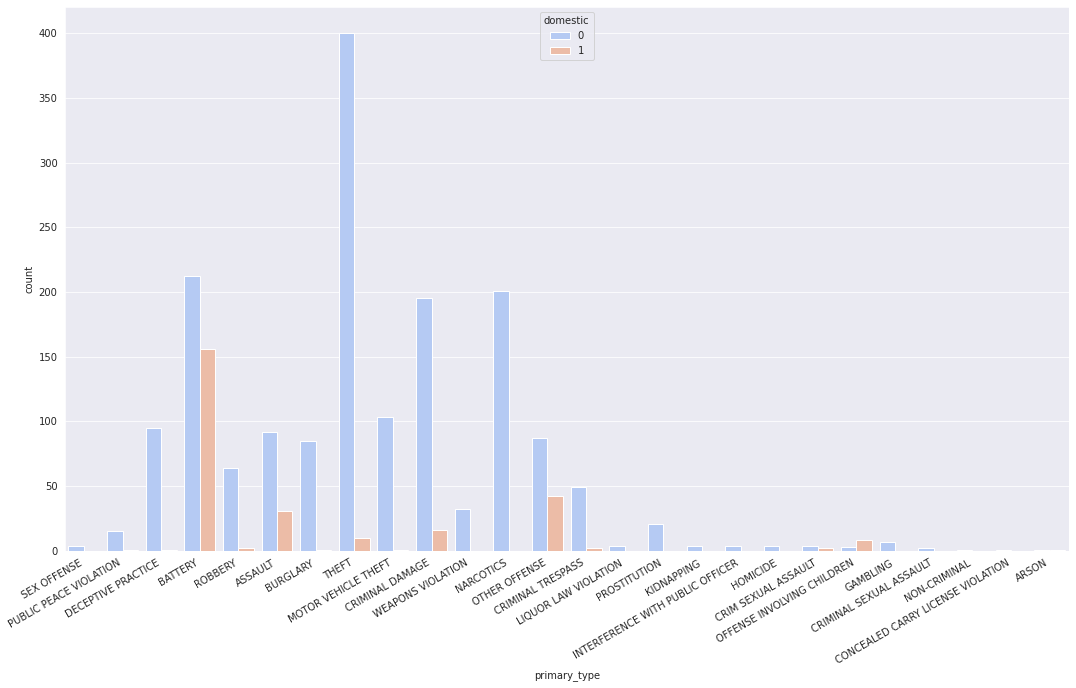

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(18,10))
plt.xticks(rotation = 30,ha = 'right')
sns.countplot(df['primary_type'],hue=df['domestic'],palette='coolwarm')

In [ ]:
df['dayofweek'] = df['date'].apply(lambda x:x.dayofweek)

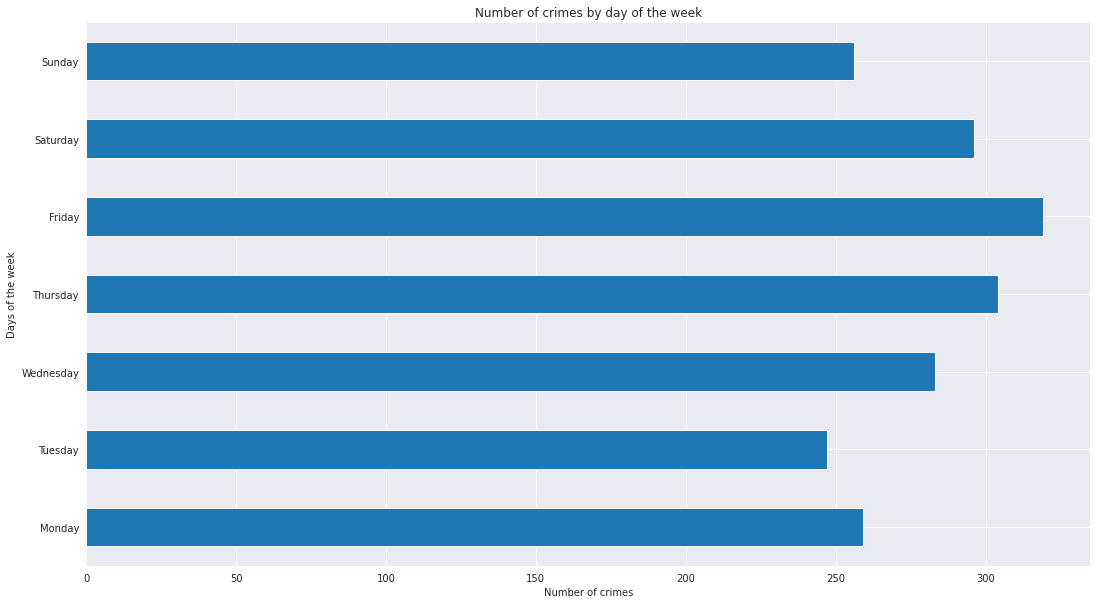

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(18,10))
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
df.groupby(['dayofweek']).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


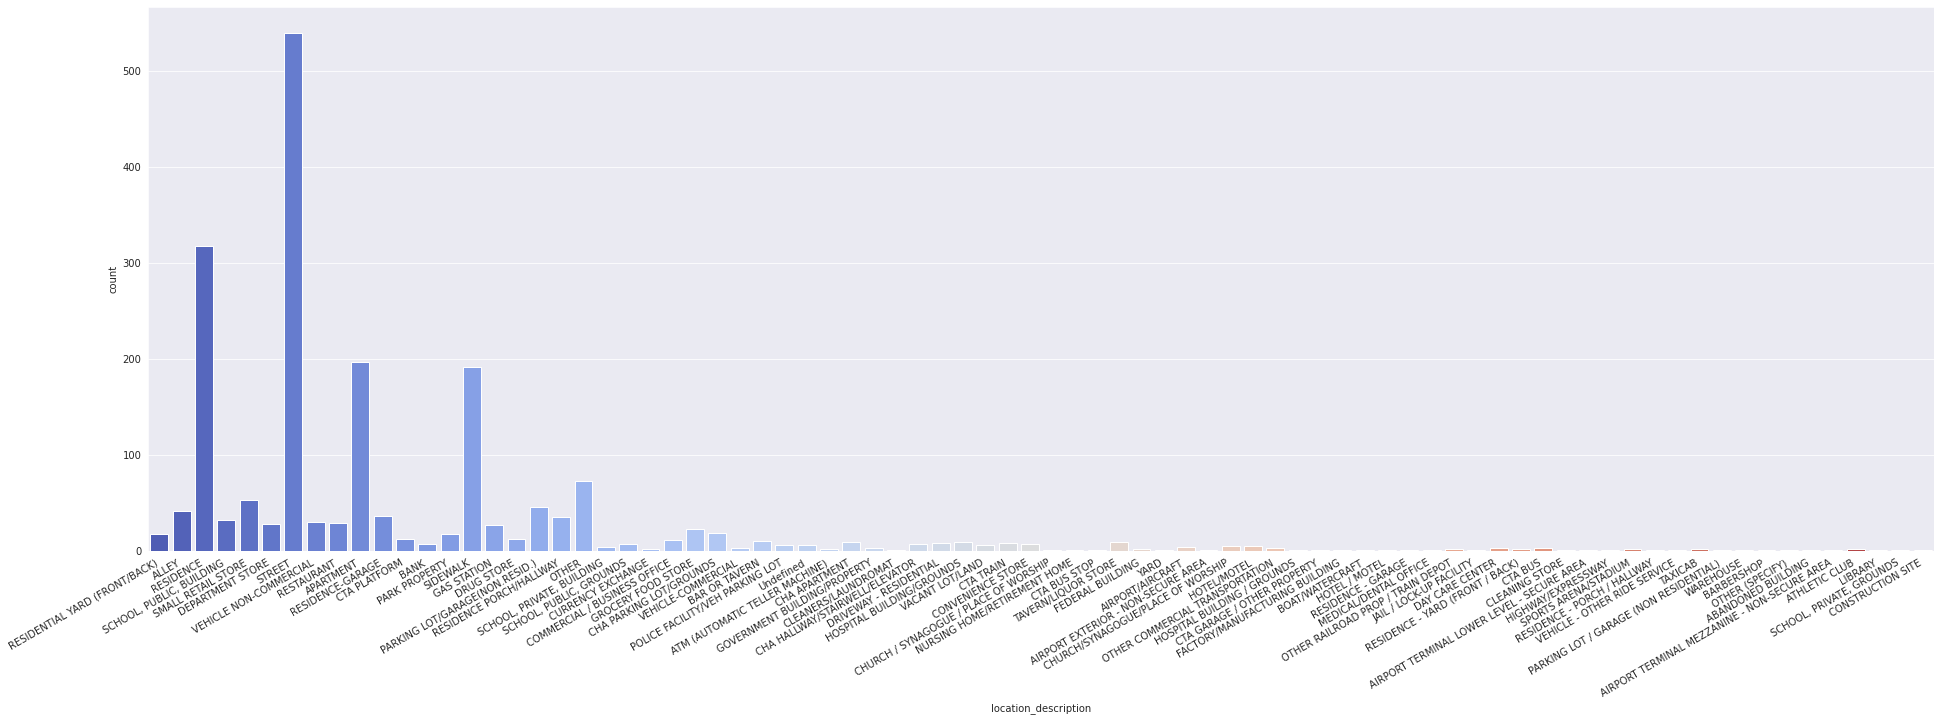

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(32,10))
plt.xticks(rotation = 30,ha = 'right')
sns.countplot(df['location_description'],palette='coolwarm')

In [ ]:
df['description'].value_counts()

SIMPLE                                                229
DOMESTIC BATTERY SIMPLE                               171
$500 AND UNDER                                        169
TO PROPERTY                                           116
OVER $500                                             111
                                                     ... 
OBSTRUCTING IDENTIFICATION                              1
GUN OFFENDER: DUTY TO REGISTER                          1
UNLAWFUL USE OF RECORDED SOUND                          1
GUN OFFENDER: DUTY TO REPORT CHANGE OF INFORMATION      1
ATTEMPT POSSESSION CANNABIS                             1
Name: description, Length: 169, dtype: int64

In [ ]:
df['district'].value_counts()

8     153
11    129
6     114
7     106
12    105
4     103
25     97
10     96
5      92
19     91
3      89
15     87
9      86
18     86
2      84
14     81
1      81
22     74
16     64
17     56
24     56
20     34
Name: district, dtype: int64

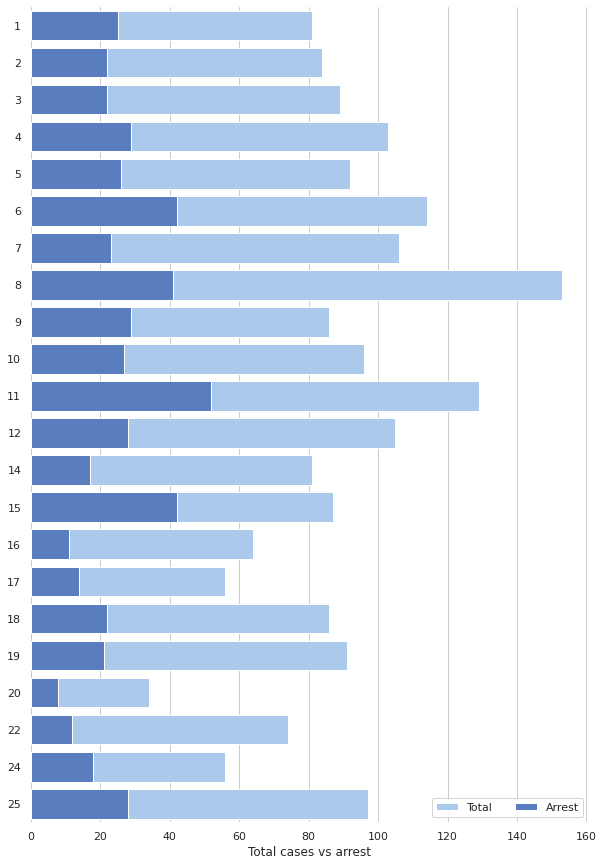

In [ ]:
district_list = []

for i in range(0,df.shape[0]):
    district = df.iloc[i].district
    arrest = df.iloc[i].arrest
    get_index = -1
    
    for j in range(0, len(district_list)):
        if (district_list[j][0] == district):
            get_index = j
            if arrest:
                district_list[j][1]+=1
            else:
                district_list[j][2]+=1
    
    if get_index == -1:
        if arrest:
            district_list.append([district, 1, 0])
        else:
            district_list.append([district, 0, 1])


get_district = pd.DataFrame(columns=['district','arrest','not_arrest'], data=district_list) 
get_district['Total'] = get_district.apply(lambda x: x.arrest+x.not_arrest, axis=1)

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 15))

# Load the example car crash dataset

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="district", data=get_district,
            label="Total", color="b", orient='h')

sns.set_color_codes("muted")
sns.barplot(x="arrest", y="district", data=get_district,
            label="Arrest", color="b", orient='h')

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Total cases vs arrest")
sns.despine(left=True, bottom=True)

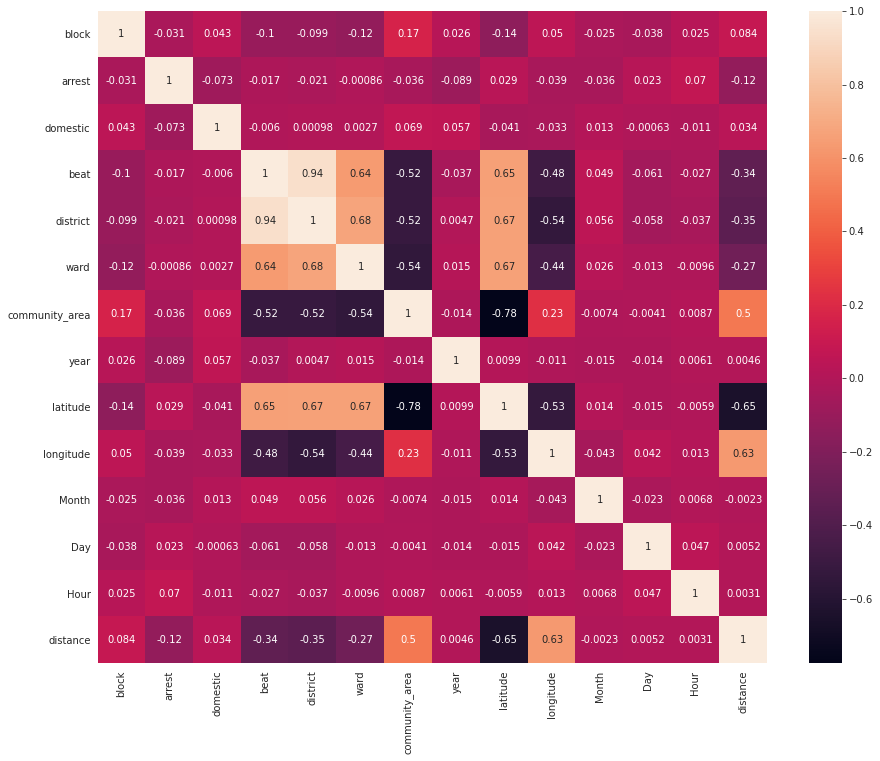

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(),annot=True)

In [ ]:
df_TS = df.set_index('date')

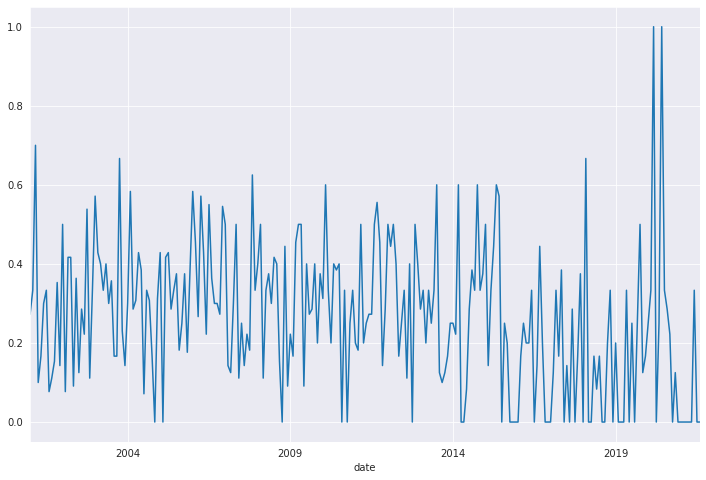

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
df_TS.resample('M')['arrest'].mean().plot()

In [ ]:
df['prim']

In [ ]:
df['ID'] = range(0,len(df)) 

In [ ]:
df = df.set_index('date')

In [ ]:
hour_by_location = df.pivot_table(values='ID', index='location_description', columns=df.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = df.pivot_table(values='ID', index='primary_type', columns=df.index.hour, aggfunc=np.size).fillna(0)
hour_by_week     = df.pivot_table(values='ID', index=df.index.hour, columns=df.index.weekday, aggfunc=np.size).fillna(0)
#hour_by_week     = hour_by_week[days].T # just reorder columns according to the the order of days
dayofweek_by_location = df.pivot_table(values='ID', index='location_description', columns=df.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = df.pivot_table(values='ID', index='primary_type', columns=df.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = df.pivot_table(values='ID', index='location_description', columns='primary_type', aggfunc=np.size).fillna(0)

In [ ]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

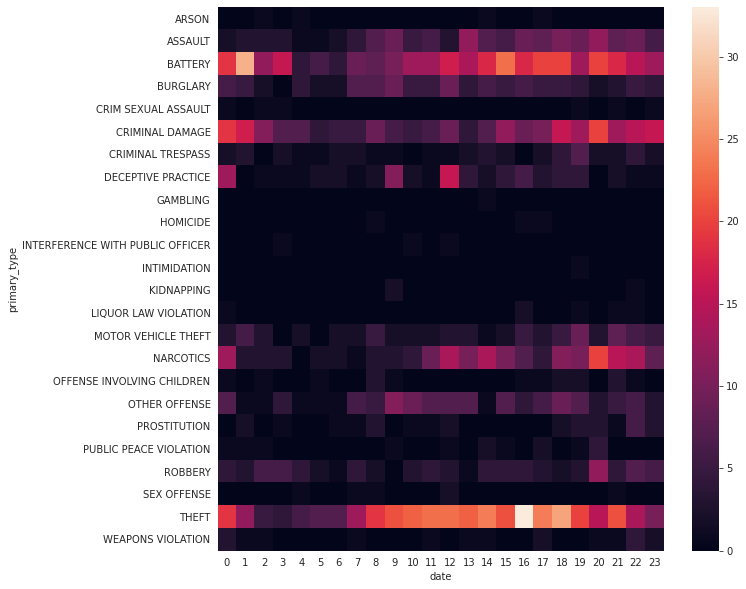

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(hour_by_type)

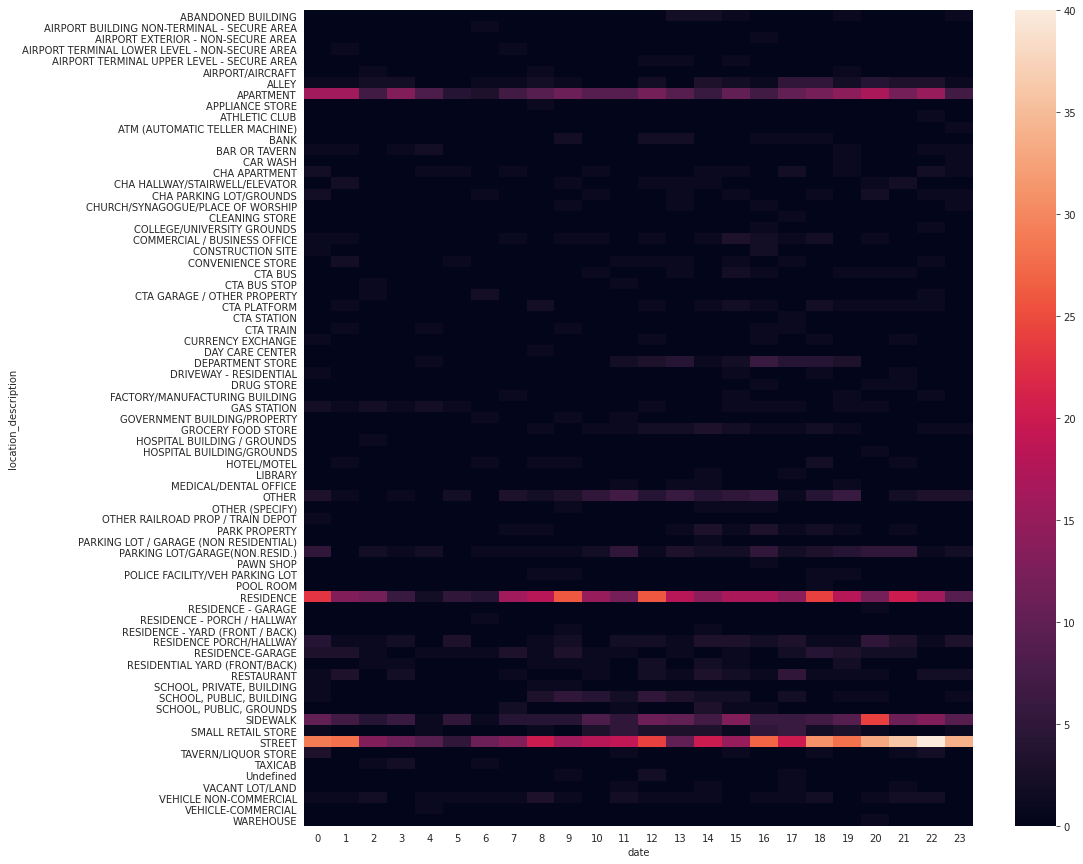

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(hour_by_location)

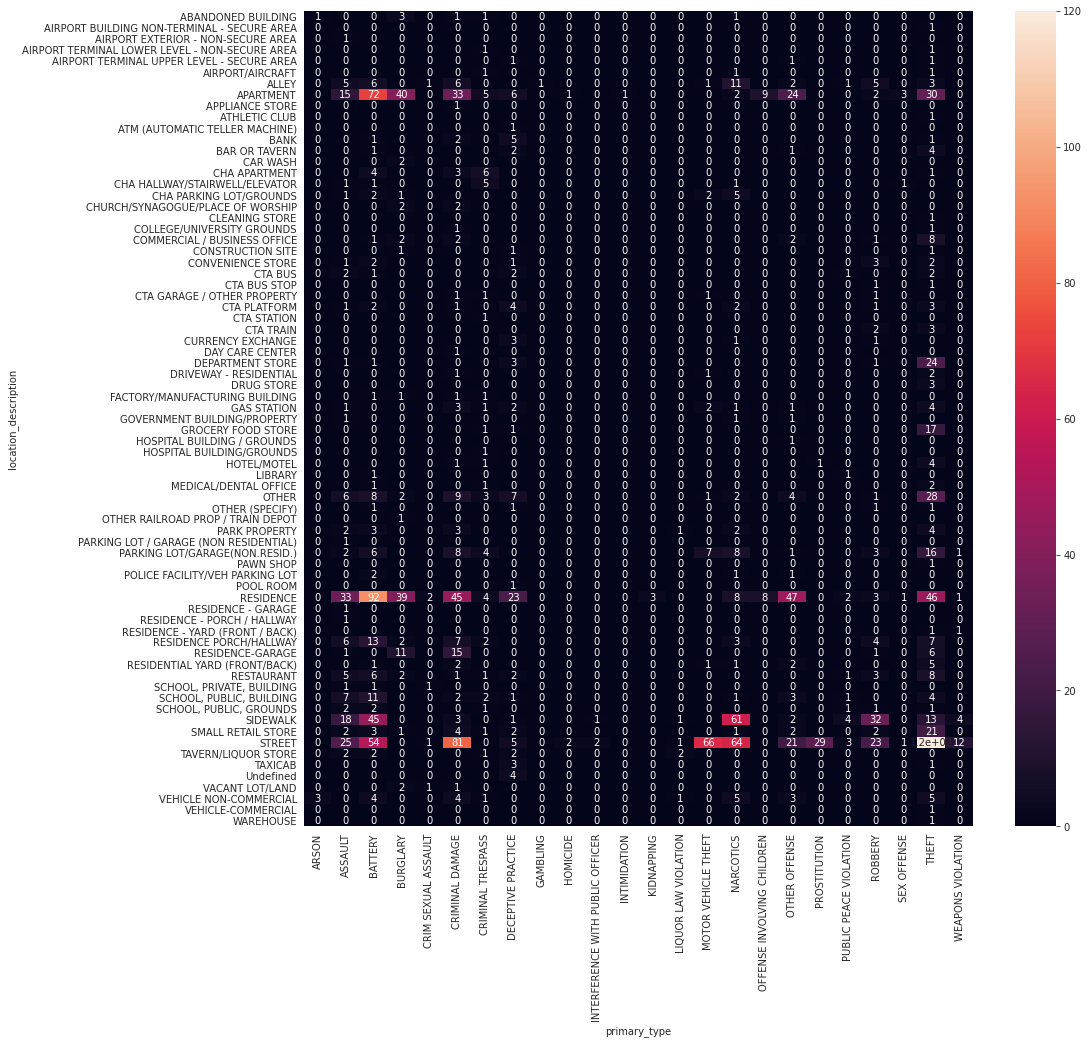

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(location_by_type,annot=True)

In [ ]:
primary_by_location = df.pivot_table(values='ID', index='location_description', columns=df['primary_type'], aggfunc=np.size).fillna(0)

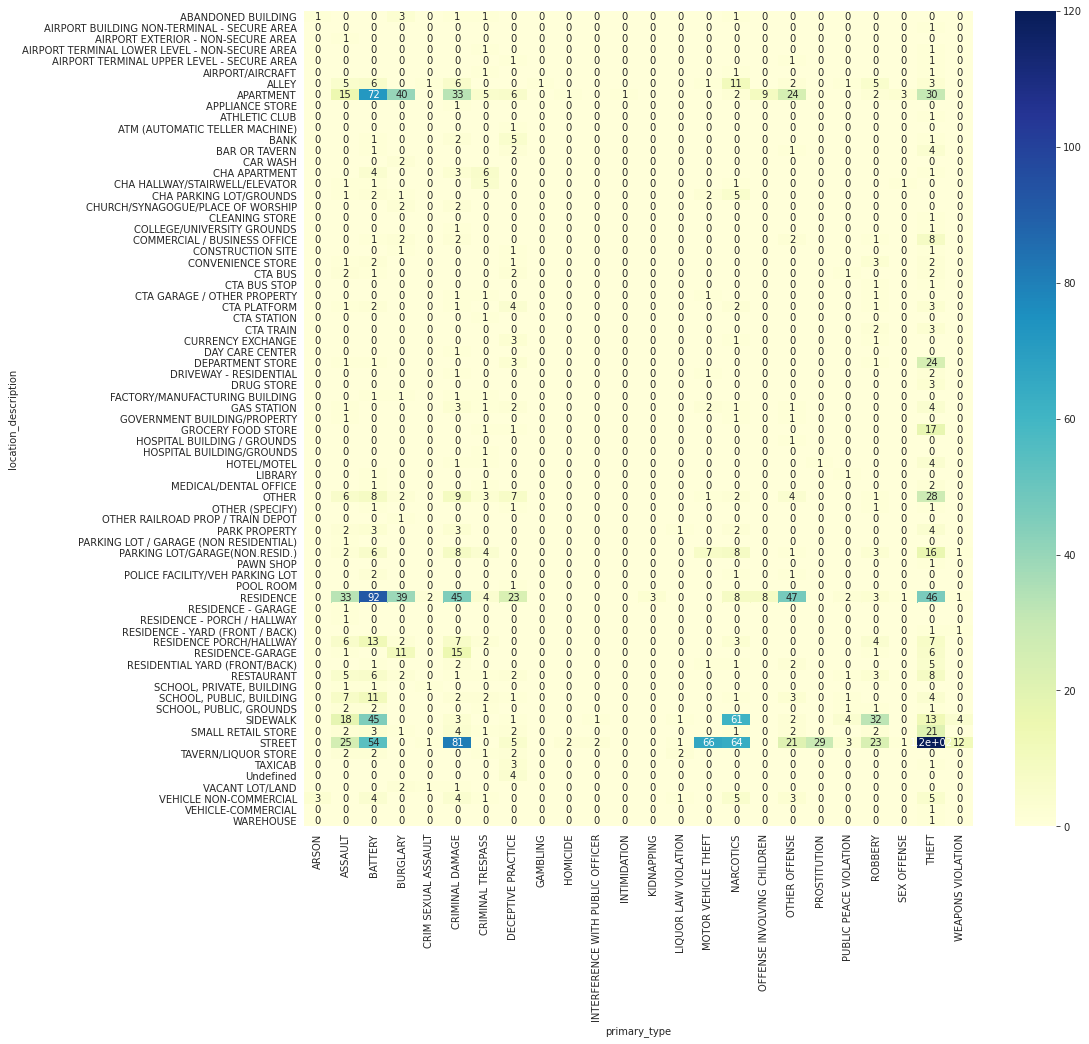

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(primary_by_location,annot=True, cmap="YlGnBu")

In [ ]:
primary_by_location = df.pivot_table(values='ID', index='Hour', columns=df.index.dayofweek, aggfunc=np.size).fillna(0)

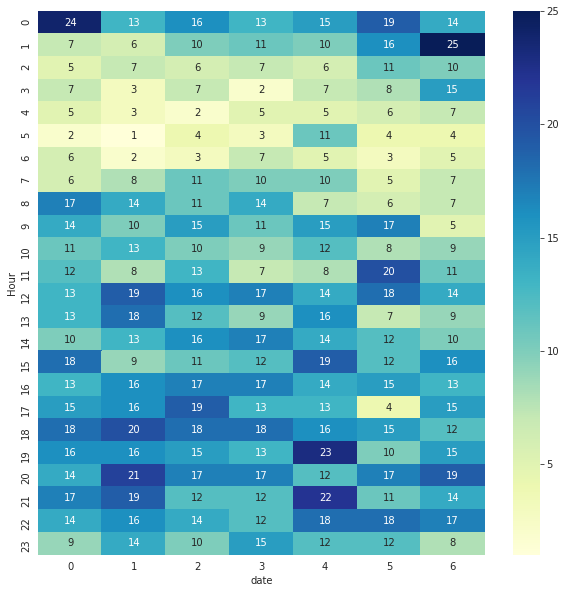

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(primary_by_location,annot=True, cmap="YlGnBu")

In [ ]:
query1 = """SELECT
  primary_type,
  description,
  COUNTIF(year = 2015) AS arrests_2015,
  COUNTIF(year = 2016) AS arrests_2016,
  FORMAT('%3.2f', (COUNTIF(year = 2016) - COUNTIF(year = 2015)) / COUNTIF(year = 2015)*100) AS pct_change_2015_to_2016
FROM
  `bigquery-public-data.chicago_crime.crime`
WHERE
  arrest = TRUE
  AND year IN (2015,
    2016)
GROUP BY
  primary_type,
  description
HAVING
  COUNTIF(year = 2015) > 100
ORDER BY
  (COUNTIF(year = 2016) - COUNTIF(year = 2015)) / COUNTIF(year = 2015) DESC
        """
response1 = chicago_crime.query_to_pandas_safe(query1)
response1.head(10)

In [ ]:
df = df.dropna()

In [ ]:
df.head()

index  block primary_type  ... Day Hour   distance
0      0      0      ROBBERY  ...  16   22  20.239317
1      1      1    NARCOTICS  ...  24   20  10.611998
2      2      2      ASSAULT  ...   7   11   8.422300
3      3      3        THEFT  ...   4   18  18.724772
4      4      4      BATTERY  ...   3   10  24.801046

[5 rows x 19 columns]

In [ ]:
df=df.reset_index()
df = df.drop('date',axis=1)


In [ ]:
df = df.drop(['latitude','longitude','ID'],axis=1)

In [ ]:
df['fbi_code'] = pd.factorize(df["fbi_code"])[0]

In [ ]:
df['community_area'] = pd.factorize(df["community_area"])[0]

In [ ]:
df['ward'] = pd.factorize(df["ward"])[0]

In [ ]:
df['district'] = pd.factorize(df["district"])[0]

In [ ]:
df['beat'] = pd.factorize(df["beat"])[0]

In [ ]:
primary = pd.get_dummies(df['primary_type'],drop_first=True)
location = pd.get_dummies(df['location_description'],drop_first=True)
description = pd.get_dummies(df['description'],drop_first=True)

In [ ]:
df = df.drop(['primary_type','description','location_description'],axis=1)

In [ ]:
df = pd.concat([df,primary,location],axis=1)

In [ ]:
df = df.drop(['latitude','longitude','index'],axis=1)

In [ ]:
df.to_csv('processed.csv')

In [ ]:
len(df)

1897

Modeling
---

In [ ]:
df['fbi_code'] = pd.factorize(df["fbi_code"])[0]
df['primary_type'] = pd.factorize(df["primary_type"])[0]
df['description'] = pd.factorize(df["description"])[0]
df['location_description'] = pd.factorize(df["location_description"])[0]
df['ward'] = pd.factorize(df["ward"])[0]
df['district'] = pd.factorize(df["district"])[0]
df['community_area'] = pd.factorize(df["community_area"])[0]

In [ ]:
df_ts = df.set_index('date')

In [ ]:
reported = df_ts.resample('B').count()['unique_key'].reset_index()
arrested = df_ts.resample('B').sum()['arrest'].reset_index()
df_t = pd.merge(reported,arrested)

In [ ]:
df_t = df_t.set_index('date')

In [ ]:
df_t['report_arrest ratio'] = df_t['arrest']/df_t['unique_key']

In [ ]:
df_t.head()

unique_key  arrest  report_arrest ratio
date                                                              
2001-01-03 00:00:00+00:00           1       0                  0.0
2001-01-04 00:00:00+00:00           0       0                  NaN
2001-01-05 00:00:00+00:00           0       0                  NaN
2001-01-08 00:00:00+00:00           2       0                  0.0
2001-01-09 00:00:00+00:00           0       0                  NaN

In [ ]:
reported_w = df_ts.resample('W').count()['unique_key'].reset_index()
arrested_w = df_ts.resample('W').sum()['arrest'].reset_index()
df_w = pd.merge(reported_w,arrested_w)
df_w = df_w.set_index('date')
df_w['report_arrest ratio'] = df_w['arrest']/df_w['unique_key']

In [ ]:

df_w.head()

unique_key  arrest  report_arrest ratio
date                                                              
2001-01-07 00:00:00+00:00           1       0             0.000000
2001-01-14 00:00:00+00:00           3       0             0.000000
2001-01-21 00:00:00+00:00           2       0             0.000000
2001-01-28 00:00:00+00:00           3       1             0.333333
2001-02-04 00:00:00+00:00           0       0                  NaN

In [ ]:
df_w.loc[df_w['report_arrest ratio'].isnull()==True,'report_arrest ratio'] = 0

In [ ]:
pd.to_datetime(df_w.index,format= '%d/%m/%Y',unit='ns')

DatetimeIndex(['2001-01-07 00:00:00+00:00', '2001-01-14 00:00:00+00:00',
               '2001-01-21 00:00:00+00:00', '2001-01-28 00:00:00+00:00',
               '2001-02-04 00:00:00+00:00', '2001-02-11 00:00:00+00:00',
               '2001-02-18 00:00:00+00:00', '2001-02-25 00:00:00+00:00',
               '2001-03-04 00:00:00+00:00', '2001-03-11 00:00:00+00:00',
               ...
               '2021-06-27 00:00:00+00:00', '2021-07-04 00:00:00+00:00',
               '2021-07-11 00:00:00+00:00', '2021-07-18 00:00:00+00:00',
               '2021-07-25 00:00:00+00:00', '2021-08-01 00:00:00+00:00',
               '2021-08-08 00:00:00+00:00', '2021-08-15 00:00:00+00:00',
               '2021-08-22 00:00:00+00:00', '2021-08-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=1078, freq=None)

In [ ]:
df_w = df_w.reset_index()
df_w['date'] = df_w['date'].apply(lambda x:datetime.date(x))

In [ ]:
df_w=df_w.set_index('date')

In [ ]:
df_w.index = pd.to_datetime(df_w.index,format='%Y/%m/%d')

In [ ]:
df_w = df_w.drop('level_0',axis=1)

In [ ]:
df_w.index = df_w.index.strftime('%Y/%m/%d')

In [ ]:
df_w.index = pd.to_datetime(df_w.index)

In [ ]:
df_w.head()

unique_key  arrest  report_arrest ratio
date                                               
2001/01/07           1       0             0.000000
2001/01/14           3       0             0.000000
2001/01/21           2       0             0.000000
2001/01/28           3       1             0.333333
2001/02/04           0       0             0.000000

In [ ]:
df_w.to_csv('weekly_Chicago_Crime3.csv')

In [ ]:
len(df_w)

1078

In [ ]:
import plotly.express as px

fig = px.line(df_w,y='report_arrest ratio', title="sample figure")
fig.show()

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(30,12))
df_w['report_arrest ratio'].iplot()

<Figure size 2160x864 with 0 Axes>

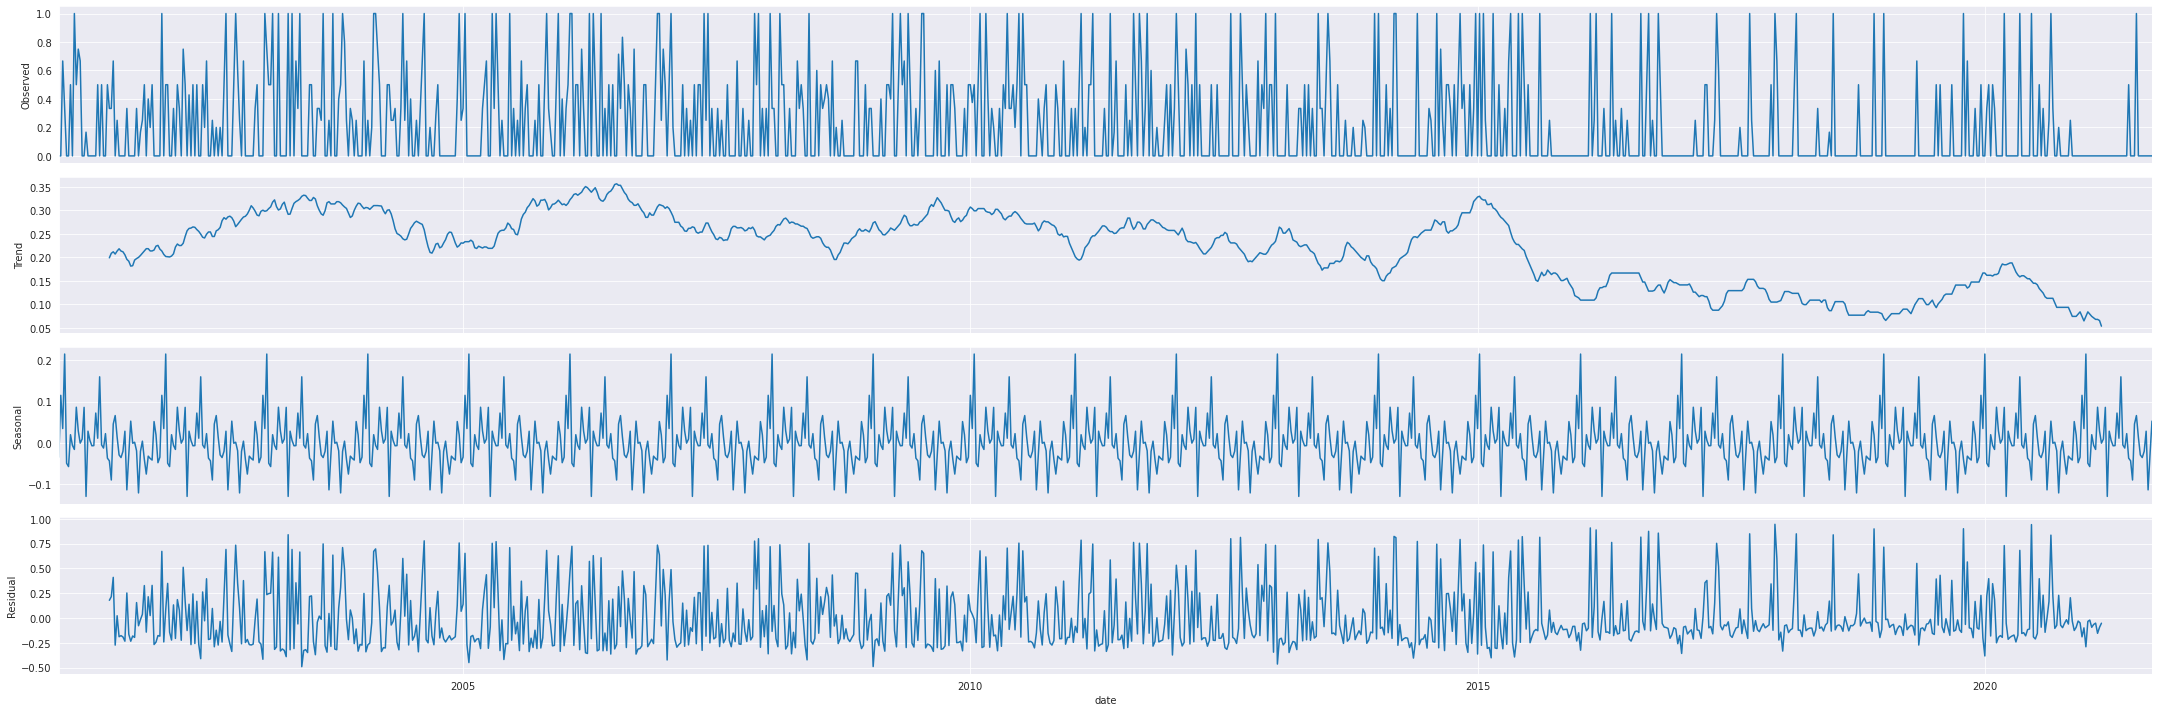

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 30,10

result = seasonal_decompose(df_w['report_arrest ratio'], model='additive')  # model='mul' also works
result.plot();

In [ ]:
df_w['6-month-SMA'] = df_w['report_arrest ratio'].rolling(window=6).mean()
df_w['12-month-SMA'] = df_w['report_arrest ratio'].rolling(window=12).mean()

<Figure size 2520x720 with 0 Axes>

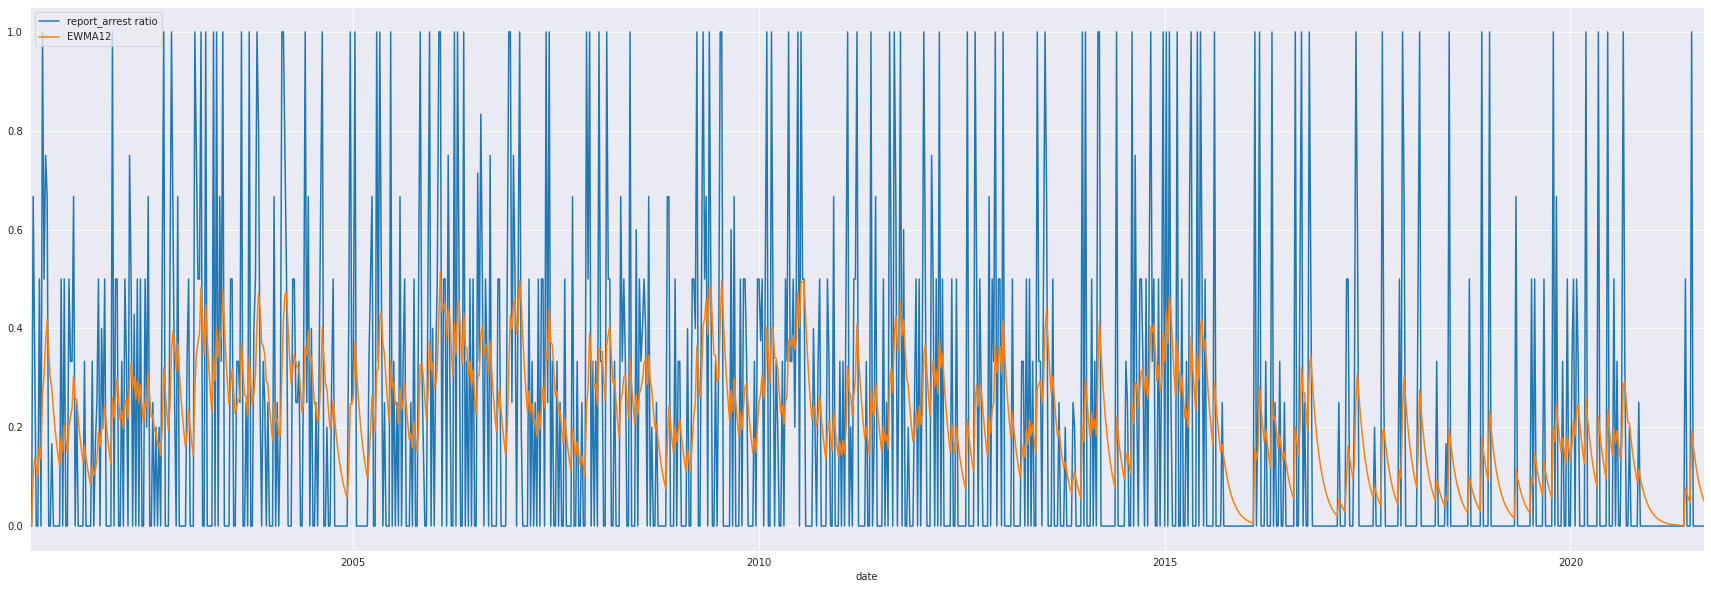

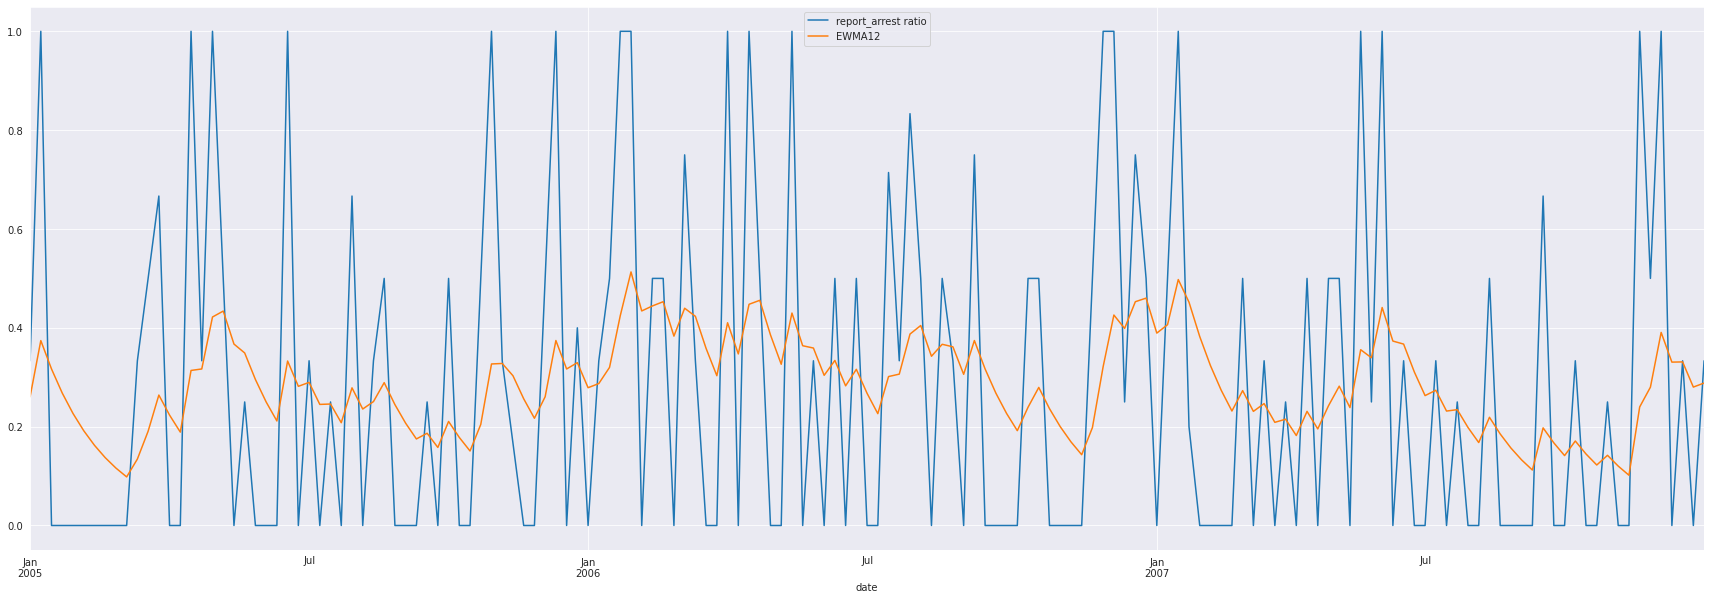

In [ ]:
df_w['EWMA12'] = df_w['report_arrest ratio'].ewm(span=12,adjust=False).mean()
plt.figure(figsize=(35,10))
df_w[['report_arrest ratio','EWMA12']].plot();
df_w.loc['2005-01-01':'2008-01-01'][['report_arrest ratio','EWMA12']].plot();

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df_w['EWMA12'] = df_w['report_arrest ratio'].ewm(alpha=alpha,adjust=False).mean()
df_w['SES12']=SimpleExpSmoothing(df_w['report_arrest ratio']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense,Activation,Input,Flatten,Conv2D,MaxPooling2D,concatenate,LSTM
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
#X = np.reshape( pd.DataFrame(df_w['report_arrest ratio']) , (-1,1))
X = df_w['report_arrest ratio'].values.astype('float32')
X = np.reshape( X , (-1,1))

In [ ]:
X

array([[0.       ],
       [0.       ],
       [0.6666667],
       ...,
       [0.       ],
       [0.       ],
       [0.       ]], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

x_train,x_test,y_train,y_test = train_test_split(df_w.index,X,random_state= 0)


In [ ]:
#y_train.dtypes

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(y_train, look_back)
testX, testY = create_dataset(y_test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
n_input = 2
n_features = 1
LSTM_generator = TimeseriesGenerator(df_w['report_arrest ratio'], df_w['report_arrest ratio'], length=n_input, batch_size=1)
LSTM_generator_test = TimeseriesGenerator(y_test, y_test, length=n_input)

In [ ]:
LSTM_model = Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
LSTM_model.add(LSTM(150, activation='relu', input_shape=(1, look_back)))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse')

In [ ]:
LSTM_model.fit(trainX,trainY,epochs=30)

Epoch 1/30
26/26 [==============================] - 2s 3ms/step - loss: 0.1410
Epoch 2/30
26/26 [==============================] - 0s 3ms/step - loss: 0.1205
Epoch 3/30
26/26 [==============================] - 0s 3ms/step - loss: 0.1108
Epoch 4/30
26/26 [==============================] - 0s 3ms/step - loss: 0.1080
Epoch 5/30
26/26 [==============================] - 0s 4ms/step - loss: 0.1070
Epoch 6/30
26/26 [==============================] - 0s 4ms/step - loss: 0.1065
Epoch 7/30
26/26 [==============================] - 0s 3ms/step - loss: 0.1060
Epoch 8/30
26/26 [==============================] - 0s 4ms/step - loss: 0.1058
Epoch 9/30
26/26 [==============================] - 0s 4ms/step - loss: 0.1059
Epoch 10/30
26/26 [==============================] - 0s 3ms/step - loss: 0.1056
Epoch 11/30
26/26 [==============================] - 0s 3ms/step - loss: 0.1055
Epoch 12/30
26/26 [==============================] - 0s 3ms/step - loss: 0.1055
Epoch 13/30
26/26 [==============================

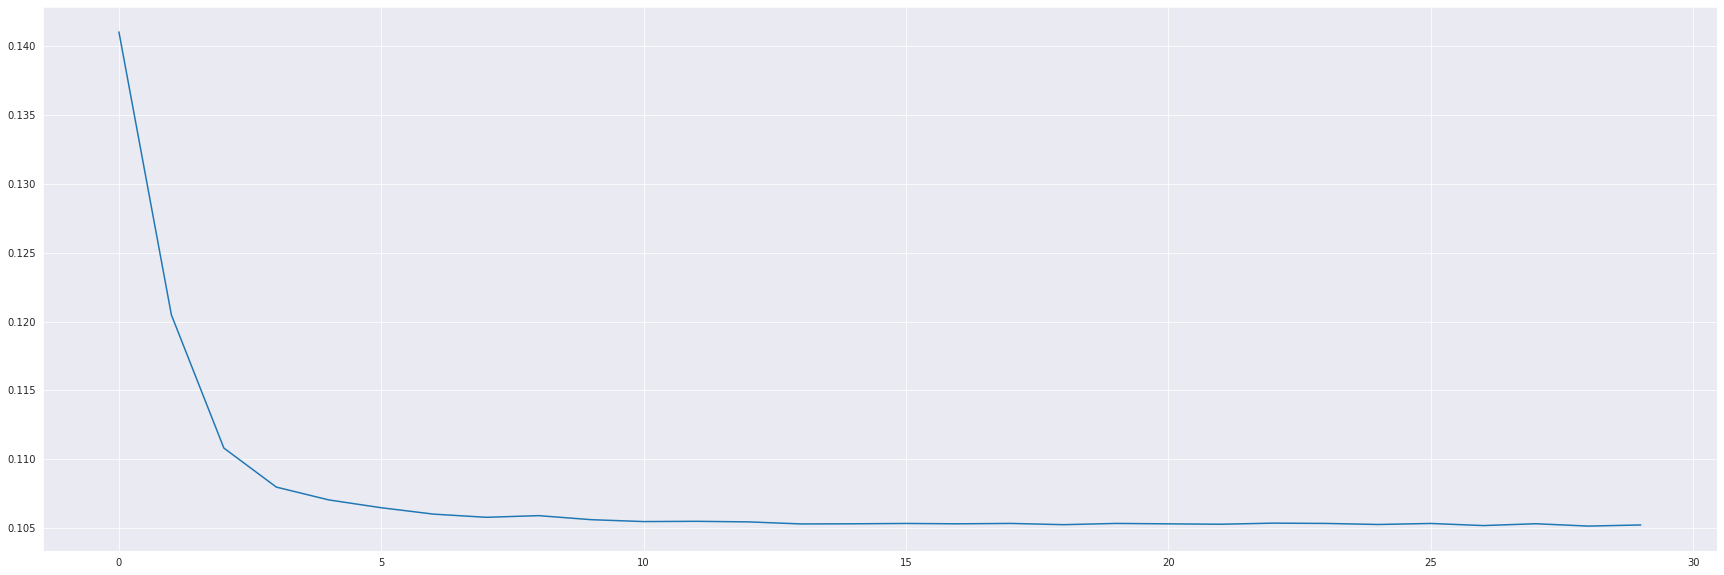

In [ ]:
LSTM_loss_per_epoch = LSTM_model.history.history['loss']
plt.plot(range(len(LSTM_loss_per_epoch)),LSTM_loss_per_epoch)


In [ ]:
import math

In [ ]:
trainPredict = LSTM_model.predict(trainX)
testPredict = LSTM_model.predict(testX)
trainY = np.reshape(trainY,(-1,1))
testY = np.reshape(testY,(-1,1))

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.32 RMSE
Test Score: 0.31 RMSE


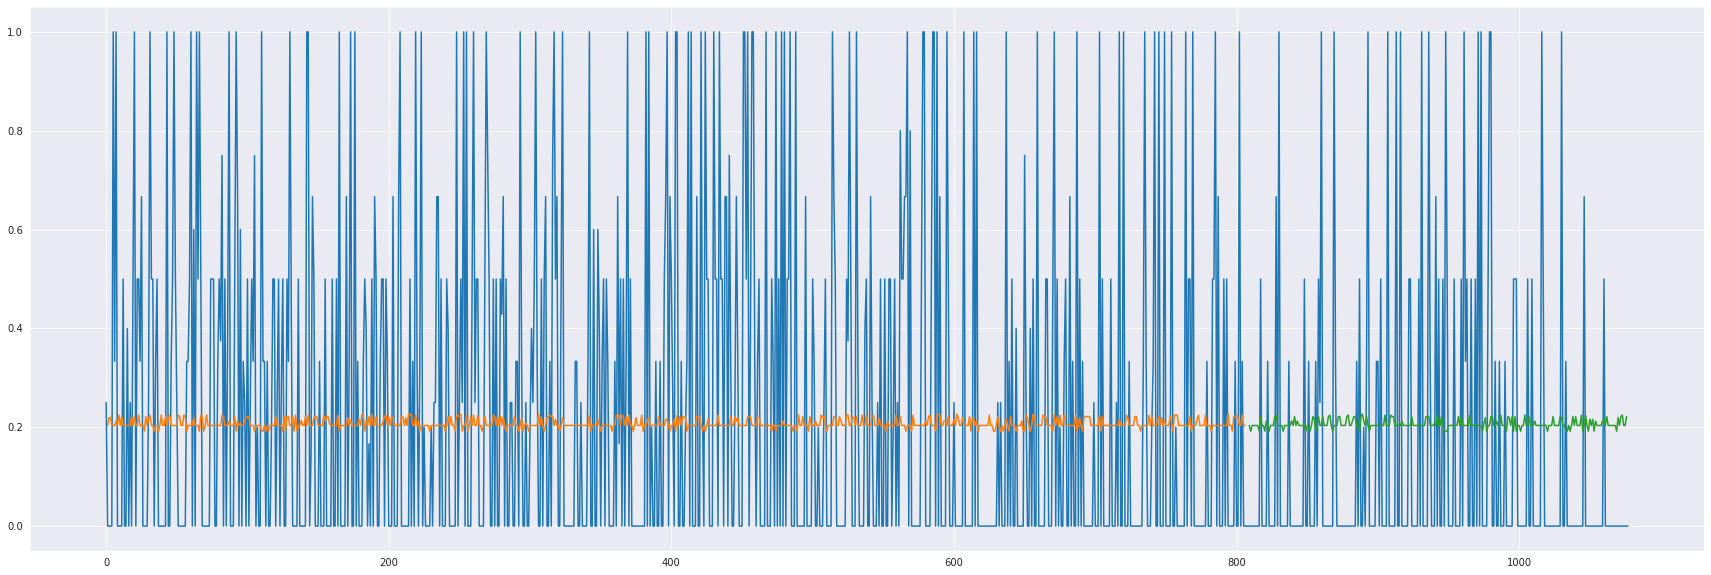

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(X)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
LSTM_test_predictions = []

first_LSTM_eval_batch = X_train_scaled[-n_input:]
current_LSTM_batch = first_LSTM_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_test)):
    current_LSTM_pred = LSTM_model.predict(current_LSTM_batch)[0]
    LSTM_test_predictions.append(current_LSTM_pred)
    current_LSTM_batch = np.append(current_LSTM_batch[:,1:,:],[[current_LSTM_pred]],axis=1)

In [ ]:
true_LSTM_predictions = scaler.inverse_transform(LSTM_test_predictions)

In [ ]:
X_test['LSTM_Prediction'] = true_LSTM_predictions

In [ ]:
from fbprophet import Prophet     #facebook prophet package

In [ ]:
df_w = df_w.reset_index()

In [ ]:
df_p = df_w[['date','report_arrest ratio']]

In [ ]:
df_p.columns = ['ds','y']

In [ ]:
df_p['ds'] = df_p['ds'].apply(lambda x:x.date)

In [ ]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(df_p)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [ ]:
future = prophet.make_future_dataframe(periods=360)  #periods = no. of days for prediction
forecast = prophet.predict(future)

In [ ]:
forecast

ds     trend  ...  multiplicative_terms_upper      yhat
0    2001-01-07  0.057069  ...                         0.0  0.345856
1    2001-01-14  0.057011  ...                         0.0  0.376040
2    2001-01-21  0.056952  ...                         0.0  0.344114
3    2001-01-28  0.056894  ...                         0.0  0.280825
4    2001-02-04  0.056836  ...                         0.0  0.244786
...         ...       ...  ...                         ...       ...
1433 2022-08-20 -0.135561  ...                         0.0  0.091242
1434 2022-08-21 -0.135595  ...                         0.0  0.092778
1435 2022-08-22 -0.135629  ...                         0.0  0.094021
1436 2022-08-23 -0.135663  ...                         0.0  0.094972
1437 2022-08-24 -0.135697  ...                         0.0  0.095640

[1438 rows x 19 columns]

<Figure size 2160x864 with 0 Axes>

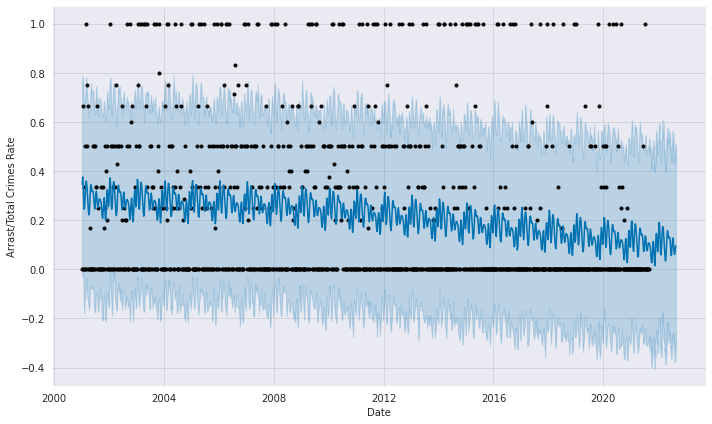

In [ ]:
plt.figure(figsize=(30,12))
figure = prophet.plot(forecast, xlabel='Date', ylabel='Arrast/Total Crimes Rate')

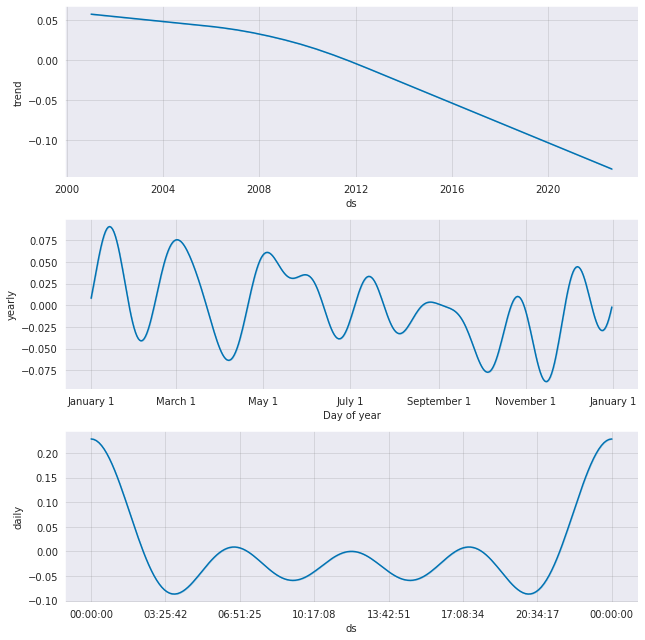

In [ ]:
figure3 = prophet.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
import itertools

In [ ]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params = []
    for param in param_iter:
        params.append(param)
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df


def train_return_results(params):
    model = Prophet(**params)
    model.fit(df_p[:])

    future = model.make_future_dataframe(periods=360, freq="W")
    forecast = model.predict(future)

    return mean_squared_error(df_p["y"][-6:], forecast["yhat"][-6:])


param_grid = {
    "changepoint_prior_scale": [0.005, 0.05, 0.5, 5],
    "changepoint_range": [0.8, 0.9],
    "seasonality_prior_scale": [0.1, 1, 10.0],
    "holidays_prior_scale": [0.1, 1, 10.0],
    "seasonality_mode": ["multiplicative", "additive"],
    # "growth": ["linear", "logistic"],
    "yearly_seasonality": [5, 10, 20],
}

# Generate all combinations of parameters
all_params = create_param_combinations(**param_grid)

# Use cross validation to evaluate all parameters
rmses = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_return_results)(dict(zip(all_params.keys(), param)))
    for param in all_params.values
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4

In [ ]:
all_params["rsme"] = rmses
best_paramers = dict(all_params.sort_values("rsme").drop("rsme", axis=1).iloc[0])
print(best_paramers)

{'changepoint_prior_scale': 0.05, 'changepoint_range': 0.9, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20}


In [ ]:
model = Prophet(**best_paramers)
model.fit(df_p)

future = model.make_future_dataframe(periods=360, freq="M")
forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
plot_plotly(model, forecast)
